In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from saturation.utils import *

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import scipy
import sklearn.metrics

In [3]:
n_cores = 24

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "300")
         .config("spark.driver.memory", "15g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/08/30 13:14:07 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/08/30 13:14:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/30 13:14:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [62]:
base_path = "/data/saturation/thesis_run_20240726_death_study/"

configs_df = F.broadcast(create_configs_df(read_configs(base_path, spark, completed_only=False)))

# For stats, select only fields we care about, alias them
craters = spark.read.parquet(f"{base_path}/3000*/craters_*.parquet")
removals = spark.read.parquet(f"{base_path}/3000*/crater_removals_*.parquet")

configs_df = F.broadcast(create_configs_df(read_configs(base_path, spark, completed_only=False)))

configs_df.createOrReplaceTempView("config")
# statistics.createOrReplaceTempView("statistics")
craters.createOrReplaceTempView("craters")
removals.createOrReplaceTempView("removals")

In [ ]:
# craters.where(F.col("radius") < 20).count()

In [ ]:
# min_simulation_id = 90
# max_simulation_id = 9999
# n_buckets = 200
# study_region_padding = 250
# study_region_size = 2000

# # max_radius, min_radius = (
# #     craters
# #         .where(F.col("simulation_id").between(min_simulation_id, max_simulation_id))
# #         .select(F.max("radius"), F.min("radius"))
# # ).collect()[0]

# min_radius = 3
# max_radius = 50

# query = f"""
# WITH lifetimes AS
# (
#     SELECT
#         simulation_id,
#         removed_crater_id AS id,
#         removed_by_crater_id - removed_crater_id AS lifetime
#     FROM
#         removals
# )
# SELECT
#     int((c.radius - {min_radius}) / {max_radius - min_radius} * {n_buckets}) AS bucket,
#     PERCENTILE_APPROX(l.lifetime, .25) AS lifetime_25_percentile,
#     PERCENTILE_APPROX(l.lifetime, .5) AS lifetime_50_percentile,
#     PERCENTILE_APPROX(l.lifetime, .75) AS lifetime_75_percentile,
#     AVG(l.lifetime) as lifetime_mean,
#     count(*) AS n
# FROM
#     lifetimes l
#     INNER JOIN craters c ON
#         c.id = l.id
#         AND c.simulation_id = l.simulation_id
# WHERE
#     l.simulation_id BETWEEN {min_simulation_id} AND {max_simulation_id}
#     AND c.x BETWEEN {study_region_padding} AND {study_region_size + study_region_size}
#     AND c.y BETWEEN {study_region_padding} AND {study_region_size + study_region_size}
#     AND c.radius BETWEEN {min_radius} AND {max_radius}
# GROUP BY
#     1
# HAVING
#     n > 5
# ORDER BY
#     1
# """
# data = spark.sql(query).toPandas()

In [8]:
n_buckets = 500
# study_region_padding = 125
# study_region_size = 1000

study_region_padding = 125
study_region_size = 1000

min_radius = 3
max_radius = 50
erat = 1

query = f"""
WITH lifetimes AS
(
    SELECT
        simulation_id,
        removed_crater_id AS id,
        removed_by_crater_id - removed_crater_id AS lifetime
    FROM
        removals
),
craters_with_config AS
(
    SELECT
        c.simulation_id,
        slope,
        erat,
        rmult,
        mrp,
        study_region_size,
        study_region_padding,
        id,
        radius
    FROM
        craters c
        INNER JOIN config cfg ON
            c.simulation_id = cfg.simulation_id
    WHERE
        1=1
        AND c.x BETWEEN study_region_padding*2 AND study_region_padding * 8
        AND c.y BETWEEN study_region_padding*2 AND study_region_padding * 8
        AND c.radius BETWEEN {min_radius} AND {max_radius} 
)
SELECT
    slope,
    erat,
    rmult,
    mrp,
    study_region_size,
    study_region_padding,
    --int(
    --    (LOG(c.radius) - LOG({min_radius})) / (LOG({max_radius}) - LOG({min_radius})) * {n_buckets}
    --) AS bucket,
    int((c.radius - {min_radius}) / {max_radius - min_radius} * {n_buckets}) as bucket,
    MEAN(c.radius) AS mean_radius,
    MEAN(PI() * c.radius * c.radius) AS mean_area,
    MEAN(POW(c.radius, -slope - 2)) AS mean_exp_lifetime_1,
    MEAN(
        (-slope * POW({min_radius / erat}, -slope) / (2 - -slope))
        * (POW({max_radius}, 2 - -slope) - POW(c.radius, 2- -slope)) / (1 - POW({min_radius / erat / max_radius}, -slope))
    ) AS mean_exp_lifetime_2,
    PERCENTILE_APPROX(l.lifetime, array(0.5, 0.10, .25, 0.5, 0.75, 0.90, 0.95)) AS lifetime_percentiles,
    STD(l.lifetime) as lifetime_stdev,
    AVG(l.lifetime) as lifetime_mean,
    count(*) AS n
FROM
    lifetimes l
    INNER JOIN craters_with_config c ON
        c.id = l.id
        AND c.simulation_id = l.simulation_id
WHERE
    1=1
GROUP BY
    1, 2, 3, 4, 5, 6, 7
HAVING
    n > 5
ORDER BY
    1, 2, 3, 4, 5, 6, 7
    
"""
data = spark.sql(query).toPandas()
# spark.sql(query).explain(mode="formatted")

In [9]:
def calculate_mean_truncated_pareto_circle_area(
    alpha: float,
    r: float,
    x_min: float,
    x_max: float
) -> float:
    part1 = alpha * x_min**alpha / (2 - alpha)
    part2 = (x_max**(2 - alpha) - r**(2-alpha)) / (1 - (x_min/x_max)**alpha)
    return np.pi * part1 * part2

In [130]:
data

,slope,erat,rmult,mrp,study_region_size,study_region_padding,bucket,mean_radius,mean_area,mean_exp_lifetime_1,mean_exp_lifetime_2,lifetime_percentiles,lifetime_stdev,lifetime_mean,n
0,-5.00,1.0,1.0,0.75,1000,125,0,3.045547,29.141694,28.255242,14.340622,"[11965, 1933, 5167, 11965, 22848, 36429, 46404]",15128.877724,16285.632823,4028315
1,-5.00,1.0,1.0,0.75,1000,125,1,3.139598,30.969228,30.954185,13.089406,"[13107, 2114, 5656, 13107, 25044, 39924, 50800]",16572.709963,17841.945219,3355441
2,-5.00,1.0,1.0,0.75,1000,125,2,3.233651,32.852360,33.819785,11.979582,"[14315, 2301, 6172, 14315, 27334, 43570, 55431]",18098.524823,19477.902129,2811956
3,-5.00,1.0,1.0,0.75,1000,125,3,3.327698,34.790966,36.856845,10.991792,"[15575, 2516, 6717, 15575, 29785, 47491, 60437]",19725.201502,21222.225104,2365853
4,-5.00,1.0,1.0,0.75,1000,125,4,3.421682,36.783786,40.068288,10.110229,"[16961, 2736, 7309, 16961, 32367, 51658, 65712]",21440.310864,23072.351532,2003655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,-1.25,1.0,1.0,0.50,1000,125,495,49.575840,7721.295439,0.053524,0.812184,"[1258, 230, 635, 1258, 2227, 3310, 4384]",1447.243689,1632.298673,452
6508,-1.25,1.0,1.0,0.50,1000,125,496,49.671945,7751.260605,0.053446,0.628010,"[1191, 226, 531, 1191, 2145, 3252, 4107]",1241.461166,1510.127907,430
6509,-1.25,1.0,1.0,0.50,1000,125,497,49.764213,7780.083648,0.053372,0.451275,"[1202, 267, 561, 1202, 2020, 3292, 4114]",1321.418054,1535.031863,408
6510,-1.25,1.0,1.0,0.50,1000,125,498,49.859189,7809.809184,0.053296,0.269436,"[1115, 163, 416, 1115, 2158, 3247, 3991]",1282.813307,1467.112440,418


In [10]:
group_columns = [
    "slope",
    "erat",
    "rmult",
    "mrp",
    "study_region_size",
    "study_region_padding",
]
data[group_columns].drop_duplicates()

,slope,erat,rmult,mrp,study_region_size,study_region_padding
0,-3.50,-1.0,1.0,0.25,1000,125
233,-1.25,1.0,1.0,0.50,1000,125


In [11]:
percentiles = [0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95]
for idx, percentile in enumerate(percentiles):
    data[f"lifetime_percentile_{int(percentile*100)}"] = data.lifetime_percentiles.apply(lambda x: x[idx])

In [17]:
slope = -3.5
erat_lookup = -1.0
erat = 1.0
mrp = 0.25
r_min = 3 / erat
r_max = study_region_size // 4

alpha = -slope

data_subset = data[(data.slope == slope) & (data.erat == erat_lookup) & (data.mrp == mrp)]
# data_subset = data[(data.slope == slope) & (data.mrp == mrp)]

In [18]:
data_subset

,slope,erat,rmult,mrp,study_region_size,study_region_padding,bucket,mean_radius,mean_area,mean_exp_lifetime_1,...,lifetime_stdev,lifetime_mean,n,lifetime_percentile_5,lifetime_percentile_10,lifetime_percentile_25,lifetime_percentile_50,lifetime_percentile_75,lifetime_percentile_90,lifetime_percentile_95
0,-3.5,-1.0,1.0,0.25,1000,125,0,3.045949,29.149386,5.316145,...,23240.972862,32334.931337,66222,27698,6939,14965,27698,44756,63607,76580
1,-3.5,-1.0,1.0,0.25,1000,125,1,3.140077,30.978653,5.564452,...,22981.007086,32535.014596,57756,28098,7159,15288,28098,44816,63673,76476
2,-3.5,-1.0,1.0,0.25,1000,125,2,3.233851,32.856432,5.815559,...,22881.530095,32573.123324,50355,28159,7265,15405,28159,44927,63386,76275
3,-3.5,-1.0,1.0,0.25,1000,125,3,3.328003,34.797319,6.071363,...,22612.685314,32606.570739,44148,28334,7461,15688,28334,45012,63070,75372
4,-3.5,-1.0,1.0,0.25,1000,125,4,3.422257,36.796164,6.331100,...,22344.999859,32613.369740,39214,28374,7719,15882,28374,44791,63055,75394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,-3.5,-1.0,1.0,0.25,1000,125,257,27.179834,2320.831329,141.700128,...,10602.715119,31487.714286,7,30080,16777,21890,30080,44432,44727,44727
229,-3.5,-1.0,1.0,0.25,1000,125,258,27.282582,2338.413205,142.504433,...,5427.479083,25641.000000,6,23859,18699,21350,23859,31766,31937,31937
230,-3.5,-1.0,1.0,0.25,1000,125,260,27.479693,2372.324564,144.051571,...,8092.518188,30732.571429,7,27940,22402,25338,27940,37284,45777,45777
231,-3.5,-1.0,1.0,0.25,1000,125,265,27.959702,2455.925823,147.842373,...,7075.042231,35370.166667,6,36194,21604,36163,36194,38536,41994,41994


<ErrorbarContainer object of 3 artists>

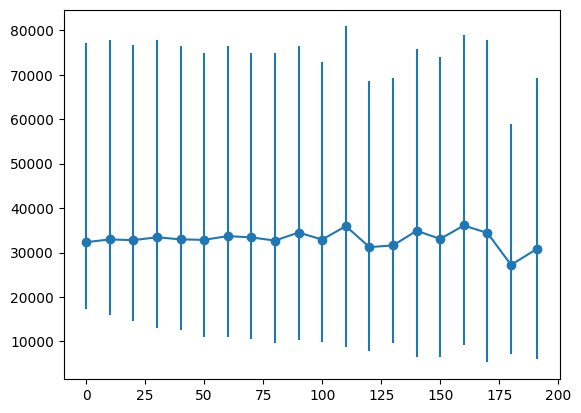

In [20]:
d = data_subset.iloc[np.array(range(20))*10]
plt.errorbar(
    d.bucket,
    d.lifetime_mean,
    yerr=[d.lifetime_percentile_25, d.lifetime_percentile_75],
    fmt="-o"
)

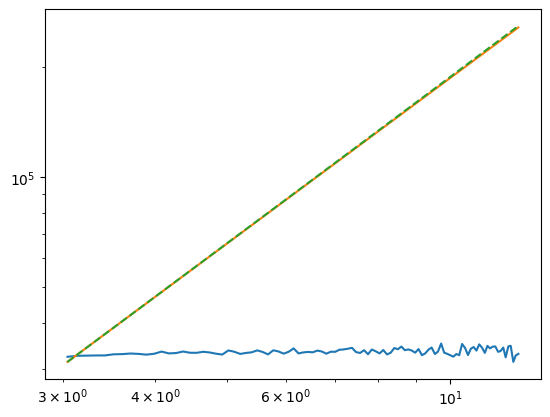

In [21]:
# Using SQL calculated values
d = data_subset[:100].reset_index()

r = d.mean_radius
plt.plot(
    r,
    d.lifetime_mean
)

expected_lifetime1 = d.mean_radius ** (alpha - 2)
expected_lifetime1 = (expected_lifetime1 / expected_lifetime1.min()) * d.lifetime_mean.min()
plt.plot(
    r,
    expected_lifetime1
)

expected_area = calculate_mean_truncated_pareto_circle_area(alpha, r, r_min, r_max)
expected_lifetime2 = np.log(mrp) / (np.log(1 - expected_area / (study_region_size + 2 * study_region_padding) ** 2))
expected_lifetime2 = (expected_lifetime2 / expected_lifetime2.min()) * d.lifetime_mean.min()
plt.plot(
    r,
    expected_lifetime2,
    ls="dashed"
)

plt.xscale("log")
plt.yscale("log")

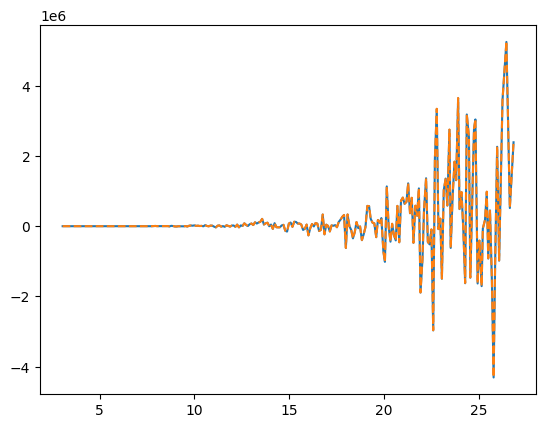

In [154]:
plt.plot(
    r,
    expected_lifetime1 - d.lifetime_mean
)

plt.plot(
    r,
    expected_lifetime2 - d.lifetime_mean,
    ls="dashed"
)

In [155]:
sklearn.metrics.mean_squared_error(d.lifetime_mean, expected_lifetime1, squared=False), sklearn.metrics.mean_squared_error(d.lifetime_mean, expected_lifetime2, squared=False)

/home/mason/code/saturation/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mason/code/saturation/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(889629.880387303), np.float64(890761.7718930672))

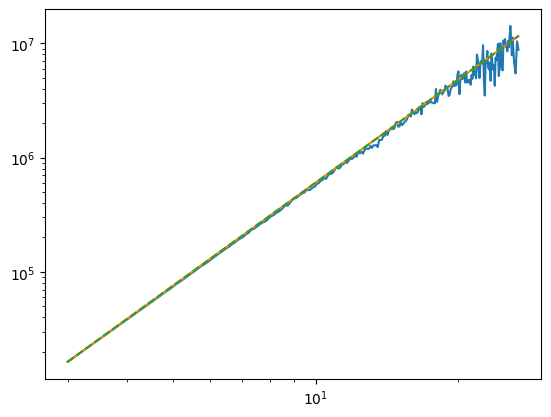

In [110]:
d = data_subset[:250].reset_index()

computed_r = np.exp((np.log(d.bucket / (n_buckets) * (max_radius - min_radius) + min_radius) + np.log(d.bucket / (n_buckets+1) * (max_radius - min_radius) + min_radius))/2)
# computed_r = d.bucket / (n_buckets + 0.5) * (max_radius - min_radius) + min_radius
plt.plot(
    computed_r,
    d.lifetime_mean
)

expected_area = calculate_mean_truncated_pareto_circle_area(alpha, computed_r, r_min, r_max)
total_area = (study_region_size + 2*study_region_padding)**2
y = np.log(mrp) / np.log(1 - expected_area / total_area)
y0 = y = (y / y.min()) * d.lifetime_mean[0]

plt.plot(
    computed_r,
    y
)

y = computed_r**(alpha - 2)
y = (y / y.min()) * d.lifetime_mean[0]

plt.plot(
    computed_r,
    y,
    ls="dashed"
)

plt.xscale("log")
plt.yscale("log")

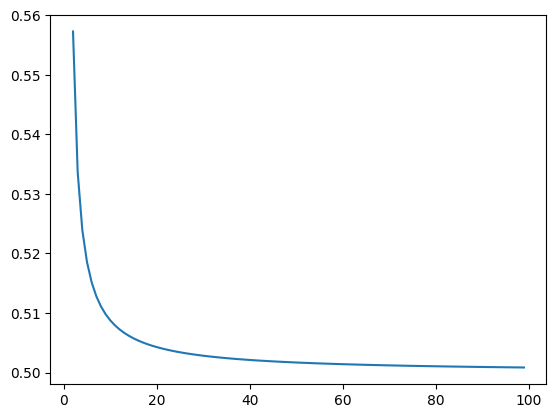

In [121]:
a = np.array(range(2, 100))
exponent = 3

simple = a**(exponent-2)
complicated = -1/np.log(1 - 1/a**(-2 + exponent))

plt.plot(
    a,
    simple - complicated
)



In [111]:

import sklearn.metrics

sklearn.metrics.mean_squared_error(d.lifetime_mean, y, squared=False), sklearn.metrics.mean_squared_error(d.lifetime_mean, y0, squared=False)


/home/mason/code/saturation/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mason/code/saturation/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(945394.4676379139), np.float64(947476.2817439185))

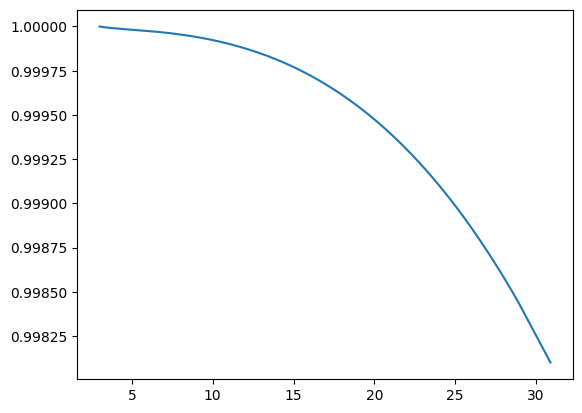

In [72]:
plt.plot(
    computed_r,
     (y/y0)
)

# plt.plot(
#     computed_r,
#      d.lifetime_mean-y0
# )

# plt.plot(
#     computed_r,
#      d.lifetime_mean-y
# )

# plt.plot(
#     computed_r,
#     (np.log(y) / np.log(d.lifetime_mean))
# )

# plt.plot(
#     computed_r,
#     np.log(y0) / np.log(d.lifetime_mean)
# )

In [ ]:
np.log(y0 / d.lifetime_mean)

In [ ]:
np.log(y / d.lifetime_mean)

In [23]:
# Calculate a rough idea of slope
(np.log(d.lifetime_mean).max() - np.log(d.lifetime_mean).min()) / (np.log(computed_r.max()) - np.log(computed_r.min()))

np.float64(3.1348004510959013)

In [24]:
(np.log(y0.max()) - np.log(y0.min())) / (np.log(computed_r.max()) - np.log(computed_r.min()))

np.float64(3.000817354235352)

In [ ]:
y0 / np.exp(d.lifetime_mean)

In [ ]:
# alpha = 2.5
y0 / np.exp(d.lifetime_mean)

In [ ]:
# alpha = 3.5
y0 / np.exp(d.lifetime_mean)

In [ ]:
np.sqrt(((y - np.exp(d.lifetime_mean))**2).sum()/len(y))

In [ ]:
np.sqrt(((y0 - np.exp(d.lifetime_mean))**2).sum()/len(y))

In [ ]:
# calculate the slope of log(r) to d
log_radii = d.bucket / n_buckets * (np.log(max_radius) - np.log(min_radius)) + np.log(min_radius)

(np.log(d.lifetime_percentile_50.max()) - np.log(d.lifetime_percentile_50.min())) / (log_radii.max() - log_radii.min())

In [ ]:
(d.lifetime_mean.max() - d.lifetime_mean.min()) / (radii.max() - radii.min())

In [ ]:
samples = np.random.pareto(5, size=10000)

In [ ]:
samples.mean()

In [ ]:
(1-samples.mean())**10000

In [ ]:
samples.max()

In [ ]:
n_repeats = 1000
alpha = 2
beta = 5
n_samples = 10000
results = []

for _ in range(n_repeats):
    samples = np.random.beta(alpha, beta, n_samples)
    m = 10 * 2 * np.pi
    for s in samples:
        m = m * (1 - s / 10000)

    results.append(m)

print(np.mean(results))
print(np.std(results))

In [ ]:
exp_mean = alpha / (alpha + beta)
exp_mean

In [ ]:
10 * 2 * np.pi * (1 - exp_mean / 10000)**n_samples

In [ ]:
(np.random.pareto(alpha, size=n_samples) * alpha * x_m).mean()

In [ ]:
np.random.beta(.5, .5, n_samples).mean()

## Point in time CSFD plots for Erat -> inf

In [4]:
from saturation.utils import *

In [5]:
def get_states_at_ntots(
    *,
    simulation_id: int,
    configs_dict: Dict,
    base_path: str,
    target_ntots: Optional[List[int]]=None,
    max_ntot: Optional[int]=int(1e6)
) -> Dict[int, pd.DataFrame]:
    """
    Returns a dict from values of ntot (a moment in time) to a dataframe of crater locations and radii at that time.
    """
    n_states = 25
    
    if not target_ntots:  
        target_ntots = [int(10**2 * 10**((x + 1) / n_states * (np.log10(max_ntot) - 2))) for x in range(n_states)]
        
    study_region_size = configs_dict[simulation_id]["study_region_size"]
    study_region_padding = configs_dict[simulation_id]["study_region_padding"]
    
    sim_name = configs_dict[simulation_id]["simulation_name"]
    sim_path = f"{base_path}/{sim_name}"
    
    stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
    craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

    max_ntot = stats_df.select(F.max("ntot")).collect()[0][0]

    target_ntots = sorted(list({x if x <= max_ntot else max_ntot for x in target_ntots}))
    
    return {
        x: get_state_at_time(
            stats_df,
            craters_df,
            removals_df,
            simulation_id,
            x,
            study_region_size,
            study_region_padding,
            spark
        )
        for x in target_ntots
    }

def estimate_slopes_for_states(states: Dict[int, pd.DataFrame]) -> pd.DataFrame:
    estimates = []
    for ntot, state in states.items():
        state = states[ntot]
        alpha, sigma = estimate_cumulative_slope(
            state.radius,
            state.radius.min(),
            state.radius.max(),
            min_search_slope=0.0,
            max_search_slope=10.0)
        estimates.append({
            "ntot": ntot,
            "alpha": alpha,
            "sigma": sigma,
        })
    return pd.DataFrame(estimates)

In [20]:
# base_path = "/data/saturation/thesis_run_20240726_death_study/"
base_path = "/data/saturation/test_effectiveness_funcs/"
# base_path = "/data/saturation/thesis_run_20240726_death_study/"

configs_df = F.broadcast(create_configs_df(read_configs(base_path, spark, completed_only=False)))

# For stats, select only fields we care about, alias them
craters = spark.read.parquet(f"{base_path}/500*/craters_*.parquet")
removals = spark.read.parquet(f"{base_path}/500*/crater_removals_*.parquet")

configs_df = F.broadcast(create_configs_df(read_configs(base_path, spark, completed_only=False)))

configs_df.createOrReplaceTempView("config")
# statistics.createOrReplaceTempView("statistics")
craters.createOrReplaceTempView("craters")
removals.createOrReplaceTempView("removals")

In [21]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

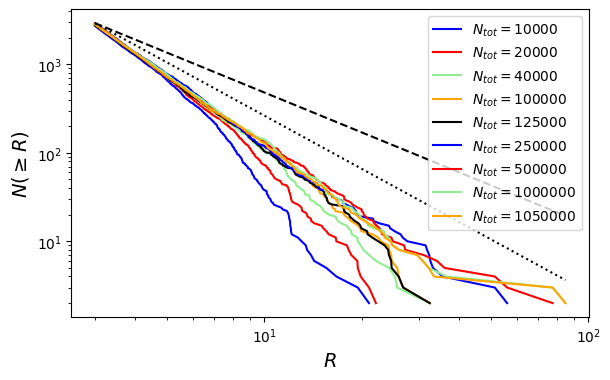

In [22]:
selected_simulation_id = 50011

states = get_states_at_ntots(simulation_id=selected_simulation_id,
                             configs_dict=configs_dict,
                             base_path=base_path,
                             target_ntots=[10000, 20000, 40000, 100000, 125000, 250000, 500000, 1000000, 3000000, 5000000])
r_max = 300
states = {
    k: v[v.radius < r_max]
    for k, v in states.items()
}

equilibrium_slope = -1.5
equilibrium_intercept1 = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())
equilibrium_intercept2 = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2
production_intercept1 = max(state.shape[0] / state.radius.min()**production_slope for state in states.values())
production_intercept2 = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept1, "--"),
    # (equilibrium_slope, equilibrium_intercept2, "--"),
    (production_slope, production_intercept1, "dotted"),
    # (production_slope, production_intercept2, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()

In [23]:
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-2.8665,0.058563
1,20000,-2.8075,0.055233
2,40000,-2.7241,0.052739
3,100000,-2.5776,0.051245
4,125000,-2.6337,0.052139
5,250000,-2.6125,0.049211
6,500000,-2.6365,0.049785
7,1000000,-2.5746,0.048762
8,1050000,-2.6564,0.049946


In [19]:
# 50105, b=-2.5, 5.0 rmult, ~1.3-1.5
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-1.4240,0.051811
1,20000,-1.4543,0.044311
2,40000,-1.2592,0.047498
3,100000,-1.4682,0.046412
4,125000,-1.2404,0.039363
5,250000,-1.2335,0.046049
6,500000,-1.4973,0.046693
7,1000000,-1.2713,0.051983
8,3000000,-1.3255,0.039227
9,5000000,-1.4666,0.046596


In [17]:
# 50104, b=-5.5, ~3.5-3.6, not stabilized
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-3.5217,0.241226
1,20000,-3.7236,0.228724
2,40000,-3.4140,0.211534
3,50000,-3.6348,0.230117


In [15]:
# 50103, b=-5.0, ~3.2
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-2.9067,0.121575
1,20000,-3.1531,0.128274
2,40000,-3.1921,0.140461
3,100000,-3.1950,0.127104
4,125000,-3.1988,0.138894
5,150000,-3.2499,0.143446


In [13]:
# 50102, b=-2.5, ~1.5-1.6
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-1.6968,0.039929
1,20000,-1.6058,0.048621
2,40000,-1.5520,0.032733
3,100000,-1.6318,0.036096
4,125000,-1.5461,0.037543
5,250000,-1.4819,0.037302
6,500000,-1.5123,0.038913
7,1000000,-1.5797,0.036786
8,3000000,-1.6677,0.035954
9,5000000,-1.5087,0.035517


In [11]:
# 50101, b=-2.0, ~1.1-1.3
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-1.3296,0.067459
1,20000,-1.3563,0.048910
2,40000,-1.1610,0.039127
3,100000,-1.2330,0.049295
4,125000,-1.2220,0.063785
5,250000,-0.9687,0.059869
6,500000,-1.2014,0.039809
7,1000000,-1.2089,0.049030
8,3000000,-1.3173,0.045564
9,5000000,-1.2005,0.042877


In [9]:
# 50100, b=-1.5, chaotic, < 1.0
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-1.0596,0.080945
1,20000,-0.9877,0.068870
2,40000,-1.0200,0.064919
3,100000,-0.9222,0.058777
4,125000,-0.7422,0.079548
5,250000,-0.7966,0.064048
6,500000,-1.0392,0.084739
7,1000000,-1.0646,0.067166
8,3000000,-0.8047,0.065906
9,5000000,-0.6829,0.069027


In [126]:
# 50009, b=-3.0, ~1.7-1.8
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-2.2072,0.035542
1,20000,-1.9692,0.027938
2,40000,-1.7572,0.025179
3,100000,-1.7441,0.026724
4,125000,-1.7183,0.024104
5,250000,-1.5756,0.026703
6,500000,-1.7169,0.025295
7,1000000,-1.8817,0.030669
8,3000000,-1.7341,0.023650
9,5000000,-1.7695,0.025105


In [124]:
# 50008, b=-3.5, ~1.8-1.9
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-1.9533,0.050317
1,20000,-1.8590,0.044936
2,40000,-1.9257,0.041610
3,100000,-1.8066,0.041751
4,125000,-1.8910,0.041321
5,250000,-1.9881,0.044200
6,500000,-1.8937,0.043334
7,1000000,-1.8469,0.039604
8,2600000,-1.0010,0.050396


In [120]:
# 50010, b=-4, ~2.2-2.3
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-2.7858,0.045145
1,20000,-2.4664,0.038715
2,40000,-2.3453,0.036220
3,100000,-2.2975,0.034923
4,125000,-2.1930,0.034341
5,250000,-2.2366,0.034167
6,500000,-2.2009,0.033164
7,1000000,-2.2434,0.033578
8,1400000,-1.6399,0.035222


In [122]:
# 50011, b=-4.5, ~2.6-2.7
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-2.8665,0.058563
1,20000,-2.8075,0.055233
2,40000,-2.7241,0.052739
3,100000,-2.5776,0.051245
4,125000,-2.6337,0.052139
5,250000,-2.6125,0.049211
6,500000,-2.6365,0.049785
7,700000,-2.7012,0.051315


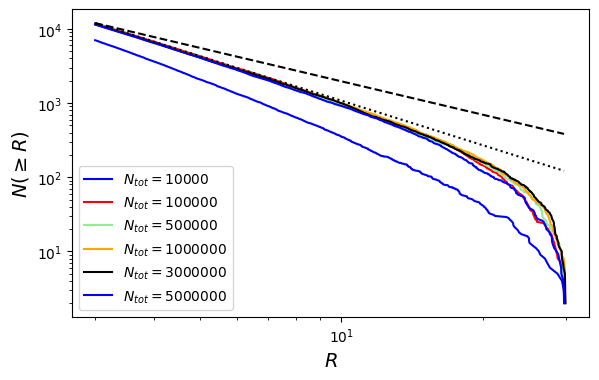

In [63]:
selected_simulation_id = 0

states = get_states_at_ntots(simulation_id=selected_simulation_id,
                             configs_dict=configs_dict,
                             base_path=base_path,
                             target_ntots=[10000, 100000, 500000, 1000000, 3000000, 5000000])
r_max = 30
states = {
    k: v[v.radius < r_max]
    for k, v in states.items()
}

equilibrium_slope = -1.5
equilibrium_intercept1 = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())
equilibrium_intercept2 = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2
production_intercept1 = max(state.shape[0] / state.radius.min()**production_slope for state in states.values())
production_intercept2 = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept1, "--"),
    # (equilibrium_slope, equilibrium_intercept2, "--"),
    (production_slope, production_intercept1, "dotted"),
    # (production_slope, production_intercept2, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()

In [64]:
estimate_slopes_for_states(states)

,ntot,alpha,sigma
0,10000,-2.3578,0.030120
1,100000,-1.9805,0.020517
2,500000,-2.0030,0.020855
3,1000000,-1.9589,0.020735
4,3000000,-1.9560,0.020697
5,5000000,-1.9899,0.021067


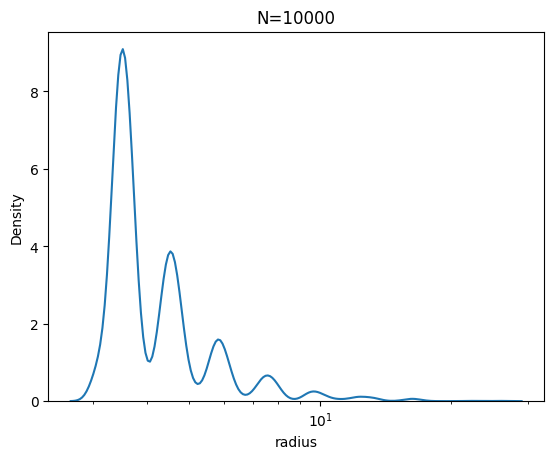

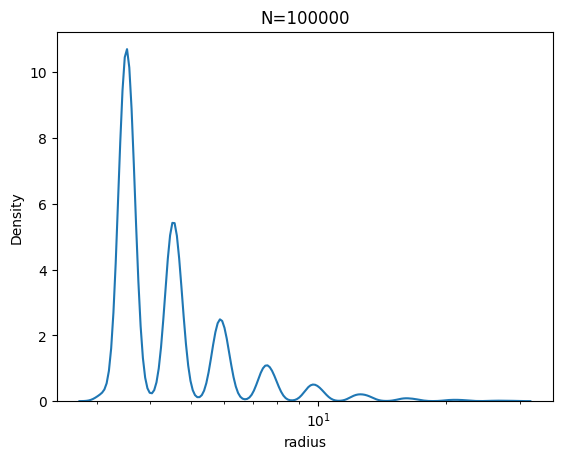

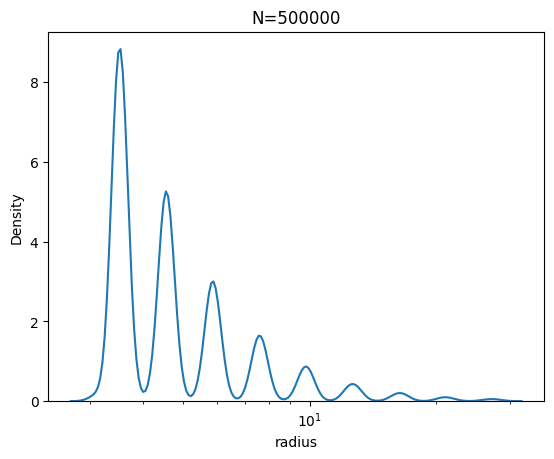

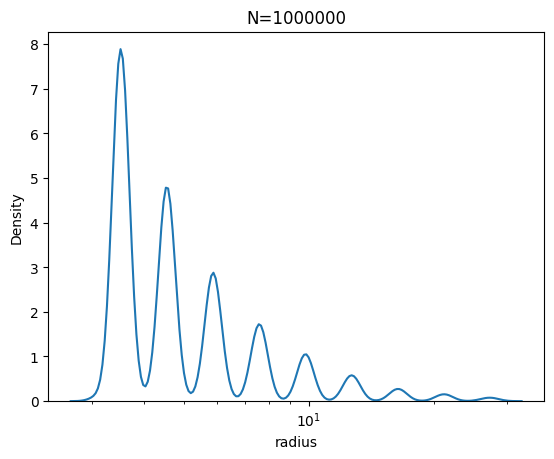

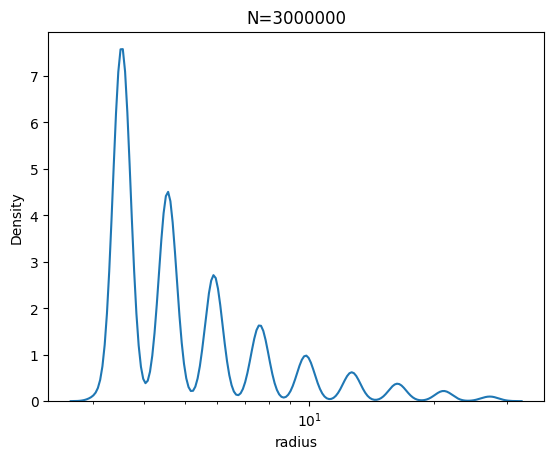

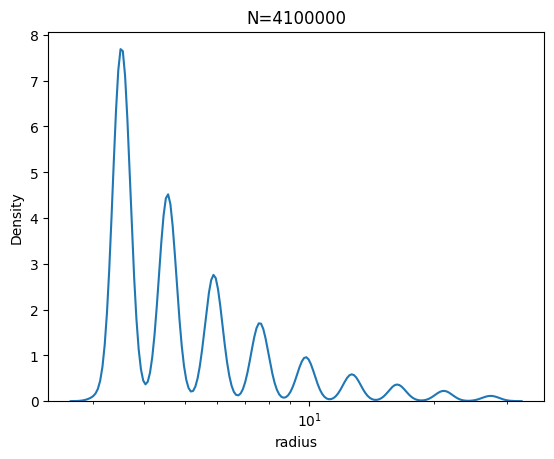

In [42]:
import seaborn as sns

for k in states.keys():
    s = states[k]
    sns.kdeplot(s.radius[s.radius < 100], log_scale=True, bw_adjust=0.75)
    plt.title(f"N={k}")
    plt.show()

In [68]:
def area_on_circle(radius: float, distance: float) -> float:
    return np.sqrt(radius**2 + distance**2)

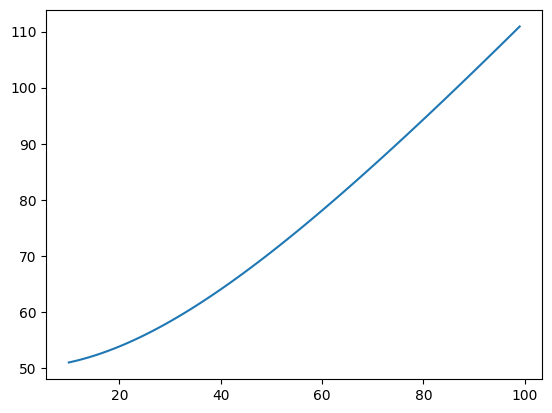

In [74]:
# radii = np.array(range(1, 100))
# distances = np.array([150] * len(radii))

distances = np.array(range(10, 100))
radii = np.array([50] * distances.shape[0])

plt.plot(
    distances,
    area_on_circle(radii, distances)
)